In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [3]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [5]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [7]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

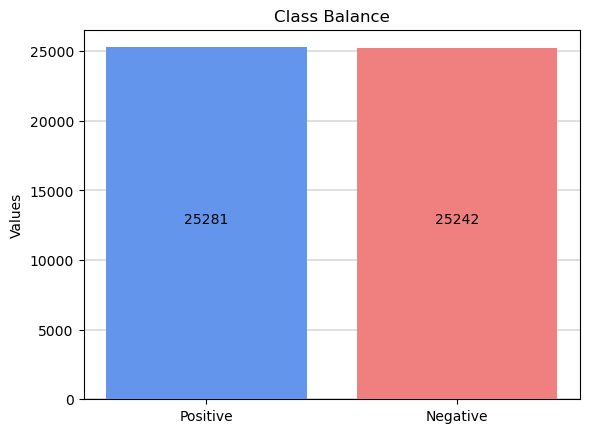

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [11]:
# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [13]:
#Split data 90% data train and 10% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(45470, 3445) (45470,)
(5053, 3445) (5053,)


In [15]:
tf_idf_len

3445

In [17]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [19]:
x_train.shape

(45470, 3445, 1)

In [21]:
y_train.shape

(45470,)

In [23]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Menentukan model CNN
def cnn(x_train, y_train, x_test, y_test):
    
    model = Sequential()
    model.add(Input(shape=(tf_idf_len, 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    optimizer = Adam(learning_rate=0.001)
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")
    
    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))

    
    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d               │ (None, 3445, 1)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3441, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     7,045,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 328s 228ms/step - accuracy: 0.7170 - loss: 0.4957 - val_accuracy: 0.8203 - val_loss: 0.3794
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 323s 228ms/step - accuracy: 0.7729 - loss: 0.4055 - val_accuracy: 0.8249 - val_loss: 0.3556
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 323s 227ms/step - accuracy: 0.7903 - loss: 0.3779 - val_accuracy: 0.8274 - val_loss: 0.3676
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 320s 225ms/step - accuracy: 0.8032 - loss: 0.3533 - val_accuracy: 0.8213 - val_loss: 0.3687
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 310s 218ms/step - accuracy: 0.8098 - loss: 0.3354 - val_accuracy: 0.8207 - val_loss: 0.3668


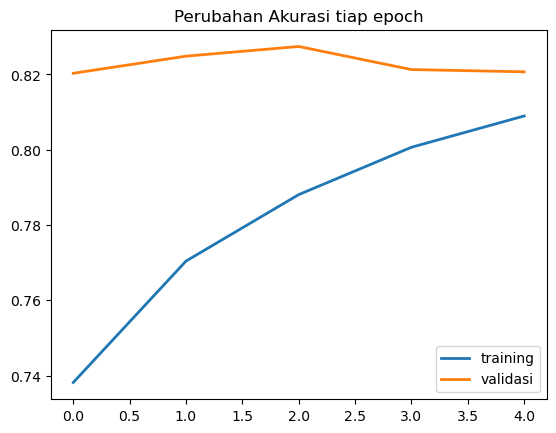

158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.839642  0.801165  0.819952      2575
           1   0.802773  0.841001  0.821443      2478

    accuracy                       0.820701      5053
   macro avg   0.821208  0.821083  0.820697      5053
weighted avg   0.821562  0.820701  0.820683      5053



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1             │ (None, 3445, 1)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3441, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     7,045,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 306s 214ms/step - accuracy: 0.7205 - loss: 0.4987 - val_accuracy: 0.8169 - val_loss: 0.3844
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 304s 214ms/step - accuracy: 0.7710 - loss: 0.4035 - val_accuracy: 0.8235 - val_loss: 0.3695
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 305s 214ms/step - accuracy: 0.7896 - loss: 0.3754 - val_accuracy: 0.8270 - val_loss: 0.3635
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 305s 214ms/step - accuracy: 0.8043 - loss: 0.3547 - val_accuracy: 0.8181 - val_loss: 0.3784
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 303s 213ms/step - accuracy: 0.8137 - loss: 0.3316 - val_accuracy: 0.8221 - val_loss: 0.3714
Epoch 6/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 304s 214ms/step - accuracy: 0.8237 - loss: 0.3098 - val_accuracy: 0.8154 - val_loss: 0.3768


158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.846999  0.778252  0.811172      2575
           1   0.787495  0.853914  0.819361      2478

    accuracy                       0.815357      5053
   macro avg   0.817247  0.816083  0.815266      5053
weighted avg   0.817818  0.815357  0.815188      5053



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2             │ (None, 3445, 1)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3441, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1720, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     7,045,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 309s 216ms/step - accuracy: 0.7251 - loss: 0.4938 - val_accuracy: 0.8253 - val_loss: 0.3707
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 306s 215ms/step - accuracy: 0.7730 - loss: 0.4053 - val_accuracy: 0.8292 - val_loss: 0.3578
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 308s 217ms/step - accuracy: 0.7939 - loss: 0.3725 - val_accuracy: 0.8274 - val_loss: 0.3592
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 308s 216ms/step - accuracy: 0.8023 - loss: 0.3527 - val_accuracy: 0.8274 - val_loss: 0.3662
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 308s 217ms/step - accuracy: 0.8120 - loss: 0.3327 - val_accuracy: 0.8241 - val_loss: 0.3690


158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.822494  0.834951  0.828676      2575
           1   0.825748  0.812752  0.819199      2478

    accuracy                       0.824065      5053
   macro avg   0.824121  0.823852  0.823937      5053
weighted avg   0.824090  0.824065  0.824028      5053



In [27]:
result = []
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))

In [29]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8200408997955009
Average Precision : 0.8053390343810142
Average Recall    : 0.8358891579230562
Average F1-Score  : 0.8200008104706127
